In [1]:
import sys
# sys.path.append("Codes/")
# import TMPD_understanding_tasks.py
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.proportion import proportions_ztest
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
pd.set_option("display.max_rows", 20)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)


In [2]:
# Read the content of each sheet
reference_window_df = pd.read_excel("Input/Test/GPT_ConceptDrift_Samples.xlsx", sheet_name='Reference Window')
detection_window_df = pd.read_excel("Input/Test/GPT_ConceptDrift_Samples.xlsx", sheet_name='Detection Window')

# Filter rows where any of the frequency columns are greater than 0
reference_window_df = reference_window_df[reference_window_df["Frequency"] > 0].dropna(how='all')
detection_window_df = detection_window_df[detection_window_df["Frequency"] > 0].dropna(how='all')

# Extracting features
features = set(reference_window_df.columns) - {'From', 'To'}

# Add suffixes to columns except 'From' and 'To'
reference_window_df_aux = reference_window_df.add_suffix('_ref').rename(columns={'From_ref': 'From', 'To_ref': 'To'})
detection_window_df_aux = detection_window_df.add_suffix('_det').rename(columns={'From_det': 'From', 'To_det': 'To'})

# Perform an outer join and fill missing values with zeros
merged_df = pd.merge(reference_window_df_aux, detection_window_df_aux, on=['From', 'To'], how='outer').fillna(0)

# Identify unique transitions and variables in both sheets
reference_window_transitions = set(reference_window_df[['From', 'To']].apply(tuple, axis=1))
detection_window_transitions = set(detection_window_df[['From', 'To']].apply(tuple, axis=1))
unique_transitions = reference_window_transitions.union(detection_window_transitions)

# Extracting activities from the transitions
reference_window_activities = set(reference_window_df['From']).union(set(reference_window_df['To']))
detection_window_activities = set(detection_window_df['From']).union(set(detection_window_df['To']))


# Localization

In [3]:
# Helper function to identify the type of variable
def identify_statistical_test(series):
    """
    Identify the type of variable based on its values.
    - 'proportion' if values are between 0 and 1.
    - 'continuous' otherwise.
    """
    if np.all((series >= 0) & (series <= 1)):
        return 'proportion_test'
    return 'count_test'

# Function to perform count test (Chi-squared or Fisher's exact test)
def perform_count_test(row, transition, variable_ref, variable_det):
    freq_reference = row[variable_ref]
    freq_detection = row[variable_det]
    total_freq_reference = merged_df[variable_ref].sum() - freq_reference
    total_freq_detection = merged_df[variable_det].sum() - freq_detection
    contingency_table = [[freq_reference, total_freq_reference], [freq_detection, total_freq_detection]]

    if 0 in contingency_table or min(min(contingency_table)) < 5:
        _, p_value = fisher_exact(contingency_table)
    else:
        _, p_value, _, _ = chi2_contingency(contingency_table)
    return p_value

    
def perform_proportions_test(row, transition, variable_ref, variable_det):
    prob_reference = row[variable_ref]
    prob_detection = row[variable_det]
    total_count_reference = merged_df.loc[merged_df['From'] == transition[0], 'Frequency_ref'].sum()
    total_count_detection = merged_df.loc[merged_df['From'] == transition[0], 'Frequency_det'].sum()

    success_reference = int(round(prob_reference * total_count_reference))
    success_detection = int(round(prob_detection * total_count_detection))


    if total_count_reference > 0 and total_count_detection > 0:
        stat, p_value = proportions_ztest([success_reference, success_detection], 
                                          [total_count_reference, total_count_detection])
        return p_value
    else:
        return None  # Not enough data to perform the test
    

def localization_task(threshold=0.05):
    # Initialize a dictionary to store the results
    localization_results = pd.DataFrame(columns=['transition', 'feature', 'p_value', 'ref_value', 'det_value', 'dif_value'])#

    # Perform statistical tests for each variable and transition
    i=0
    for index, row in merged_df.iterrows():
        transition = (row['From'], row['To'])

        for feature in features:

            variable_ref = feature + '_ref'
            variable_det = feature + '_det'

            ref_value = row[variable_ref]
            det_value = row[variable_det]

            # Check if the feature is a proportion or count
            test_type = identify_statistical_test(merged_df[[variable_ref, variable_det]].values.flatten())

            # Perform the appropriate statistical test
            if test_type == 'count_test':
                p_value = perform_count_test(row, transition, variable_ref, variable_det)
            else:
                p_value = perform_proportions_test(row, transition, variable_ref, variable_det)

            # Record the significant result
            if p_value is not None and p_value < threshold:
                localization_results.loc[i] = [transition, feature, p_value, ref_value, det_value, det_value - ref_value]
                i += 1

    return localization_results
   
        
# Call Localization task function
localization_results = localization_task(threshold=0.05)

# Output the results
localization_results.to_csv("localization_results.csv", index=False)
localization_results

c:\Users\anton\OneDrive\_Cloud Disk\Projetos de programação\Git\Transition_Matrix_Process_Drift\.venv\Lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std
c:\Users\anton\OneDrive\_Cloud Disk\Projetos de programação\Git\Transition_Matrix_Process_Drift\.venv\Lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std
c:\Users\anton\OneDrive\_Cloud Disk\Projetos de programação\Git\Transition_Matrix_Process_Drift\.venv\Lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


,transition,feature,p_value,ref_value,det_value,dif_value
0,"(B, C)",Frequency,3.458024e-05,50.0,100.0,50.0
1,"(B, C)",Probability,3.215263e-16,0.5,1.0,0.5
2,"(B, D)",Frequency,4.383488e-16,50.0,0.0,-50.0
3,"(B, D)",Probability,3.215263e-16,0.5,0.0,-0.5
4,"(C, E)",Frequency,4.383488e-16,50.0,0.0,-50.0
...,...,...,...,...,...,...
17,"(F, J)",Frequency,1.223379e-12,0.0,40.0,40.0
18,"(F, J)",Probability,1.537460e-12,0.0,0.4,0.4
19,"(G, J)",Frequency,6.986495e-19,0.0,60.0,60.0
20,"(G, J)",Probability,2.079055e-20,0.0,0.6,0.6


# Characterization - Basic

In [4]:
# Function to create a directed graph from transitions
def create_process_graph(df):
    graph = nx.DiGraph()
    graph.graph['graph']={'rankdir':'LR'}

    # Ensure 'START' and 'END' nodes exist
    graph.add_node('START')
    graph.add_node('END')

    for index, row in df.iterrows():
        if row['Frequency'] > 0:
            graph.add_edge(row['From'], row['To'])
    return graph


def draw_colored_graph(graph, title, localization_results, characterization_results):

    # Set transition colors
    edge_color_map = {}
    for transition in graph.edges():
        # New transitions in green
        if transition in characterization_results.loc[characterization_results['Characterization_info'] == 'New_Transition', 'Values'].values[0]:
            edge_color_map[transition] = 'green'  
        # Deleted transitions in red
        elif transition in characterization_results.loc[characterization_results['Characterization_info'] == 'Deleted_Transition', 'Values'].values[0]:
            edge_color_map[transition] = 'red'
        # Significant transitions in orange
        elif transition in set(tuple(row) for row in localization_results['transition']):
            edge_color_map[transition] = 'orange'
    edge_colors = [edge_color_map.get((u, v), 'black') for u, v in graph.edges()]


    # Set activities colors
    node_color_map = {}
    for activity in graph.nodes():
        # New start activities in blue
        if activity in characterization_results.loc[characterization_results['Characterization_info'] == 'New_Start_Activity', 'Values'].values[0]:
            node_color_map[activity] = 'blue'
        # Deleted start activities in blue
        elif activity in characterization_results.loc[characterization_results['Characterization_info'] == 'Deleted_Start_Activity', 'Values'].values[0]:
            node_color_map[activity] = 'orange'
        # New end activities in blue
        elif activity in characterization_results.loc[characterization_results['Characterization_info'] == 'New_End_Activity', 'Values'].values[0]:
            node_color_map[activity] = 'blue'
        # Deleted end activities in blue
        elif activity in characterization_results.loc[characterization_results['Characterization_info'] == 'Deleted_End_Activity', 'Values'].values[0]:
            node_color_map[activity] = 'orange'
        # New activities in green
        elif activity in characterization_results.loc[characterization_results['Characterization_info'] == 'New_Activity', 'Values'].values[0]:
            node_color_map[activity] = 'green'
        # Deleted activities in red
        elif activity in characterization_results.loc[characterization_results['Characterization_info'] == 'Deleted_Activity', 'Values'].values[0]:
            node_color_map[activity] = 'red'
    node_colors = [node_color_map.get(node, 'grey') for node in graph.nodes()]

    # Use Graphviz to create a hierarchical layout
    pos = graphviz_layout(graph, prog='dot')

    # Calculate figure size based on the number of unique transitions
    num_transitions = len(graph.edges())
    # Base width for the plot
    base_width = 10 
    # Base height for the plot 
    base_height = 3   
    # Additional size per transition
    size_per_transition = 0.3  
    fig_width = base_width + num_transitions * size_per_transition
    # Half the rate of width increase
    fig_height = base_height + num_transitions * size_per_transition * 0.5  
    
    # Adjust width and height dynamically
    plt.figure(figsize=(fig_width, fig_height))  
   
    nx.draw(graph, pos, edge_color=edge_colors, node_color=node_colors, with_labels=True, arrows=True, node_size=700, font_size=8)

    plt.title(title)
    plt.show()

In [5]:
def characterization_task(graph_reference, graph_detection):
    characterization_results = {}

    # Transitions and activities in reference and detection windows
    transitions_reference = set(graph_reference.edges())
    transitions_detection = set(graph_detection.edges())
    activities_reference = set(graph_reference.nodes())
    activities_detection = set(graph_detection.nodes())
    start_activities_reference = set(graph_reference.successors("START"))
    start_activities_detection = set(graph_detection.successors("START"))
    end_activities_reference = set(graph_reference.predecessors("END"))
    end_activities_detection = set(graph_detection.predecessors("END"))

    # New and Deleted Transitions
    # characterization_results['Transitions_Reference'] = list(transitions_reference)
    # characterization_results['Transitions_Detection'] = list(transitions_detection)
    characterization_results['New_Transition'] = list(transitions_detection - transitions_reference) 
    characterization_results['Deleted_Transition'] = list(transitions_reference - transitions_detection) 

    # New and Deleted Activities
    # characterization_results['Activities_Reference'] = list(activities_reference)
    # characterization_results['Activities_Detection'] = list(activities_detection)
    characterization_results['New_Activity'] = list(activities_detection - activities_reference)
    characterization_results['Deleted_Activity'] = list(activities_reference - activities_detection)

    # Identify start and end activities for reference and detection windows
    # characterization_results['Start_Activity_Reference'] = list(start_activities_reference)
    # characterization_results['Start_Activity_Detection'] = list(start_activities_detection)
    characterization_results['New_Start_Activity'] = list(start_activities_detection - start_activities_reference)
    characterization_results['Deleted_Start_Activity'] = list(start_activities_reference - start_activities_detection)

    # characterization_results['End_Activity_Reference'] = list(end_activities_reference)
    # characterization_results['End_Activity_Detection'] = list(end_activities_detection)
    characterization_results['New_End_Activity'] = list(end_activities_detection - end_activities_reference)
    characterization_results['Deleted_End_Activity'] = list(end_activities_reference - end_activities_detection)

    # analyze_edge_graph_patterns_reference = analyze_edge_graph_patterns(graph_reference)
    # analyze_edge_graph_patterns_detection = analyze_edge_graph_patterns(graph_detection)

    #     # Append patterns directly with differentiation
    # for pattern_type, transitions in analyze_edge_graph_patterns_reference.items():
    #     characterization_results[f'{pattern_type}_Reference'] = transitions
    # for pattern_type, transitions in analyze_edge_graph_patterns_detection.items():
    #     characterization_results[f'{pattern_type}_Detection'] = transitions

    # # Classify alpha relationships for both reference and detection windows
    # alpha_relationships_reference = classify_alpha_relationships(graph_reference)
    # alpha_relationships_detection = classify_alpha_relationships(graph_detection)

    # print(alpha_relationships_reference)
    # print(alpha_relationships_detection)

    # # Analyze patterns in reference and detection windows
    # analyze_node_graph_patterns_reference = analyze_node_graph_patterns(graph_reference)
    # analyze_node_graph_patterns_detection = analyze_node_graph_patterns(graph_detection)
        
    # # Append patterns directly with differentiation
    # for pattern_type, transitions in analyze_node_graph_patterns_reference.items():
    #     characterization_results[f'{pattern_type}_Reference'] = transitions
    # for pattern_type, transitions in analyze_node_graph_patterns_detection.items():
    #     characterization_results[f'{pattern_type}_Detection'] = transitions

    # # Remove duplicates
    # for key in characterization_results:
    #     characterization_results[key] = list(set(characterization_results[key]))

    characterization_results = pd.DataFrame([characterization_results]).transpose().reset_index()
    characterization_results.columns = ["Characterization_info", "Values"]


    return characterization_results


# Creating and analyzing graphs for reference and detection windows
graph_reference = create_process_graph(reference_window_df)
graph_detection = create_process_graph(detection_window_df)

# Call Characterization task function
characterization_results = characterization_task(graph_reference, graph_detection)

# Output the results
characterization_results.to_csv("characterization_results.csv", index=False)
characterization_results

,Characterization_info,Values
0,New_Transition,"[(F, J), (J, I), (G, J), (C, D)]"
1,Deleted_Transition,"[(C, E), (B, D), (H, I), (I, I), (F, H), (G, H)]"
2,New_Activity,[J]
3,Deleted_Activity,[H]
4,New_Start_Activity,[]
5,Deleted_Start_Activity,[]
6,New_End_Activity,[]
7,Deleted_End_Activity,[]


C:\Users\anton\AppData\Local\Temp\ipykernel_3096\402108352.py:57: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog='dot')


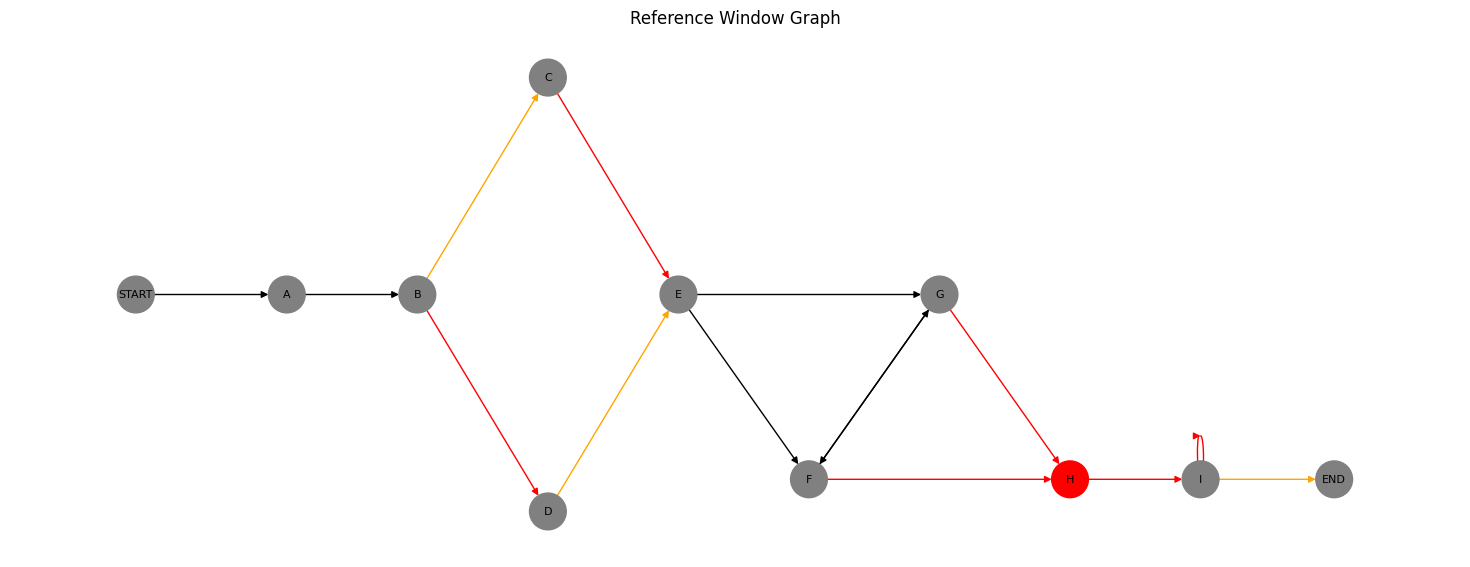

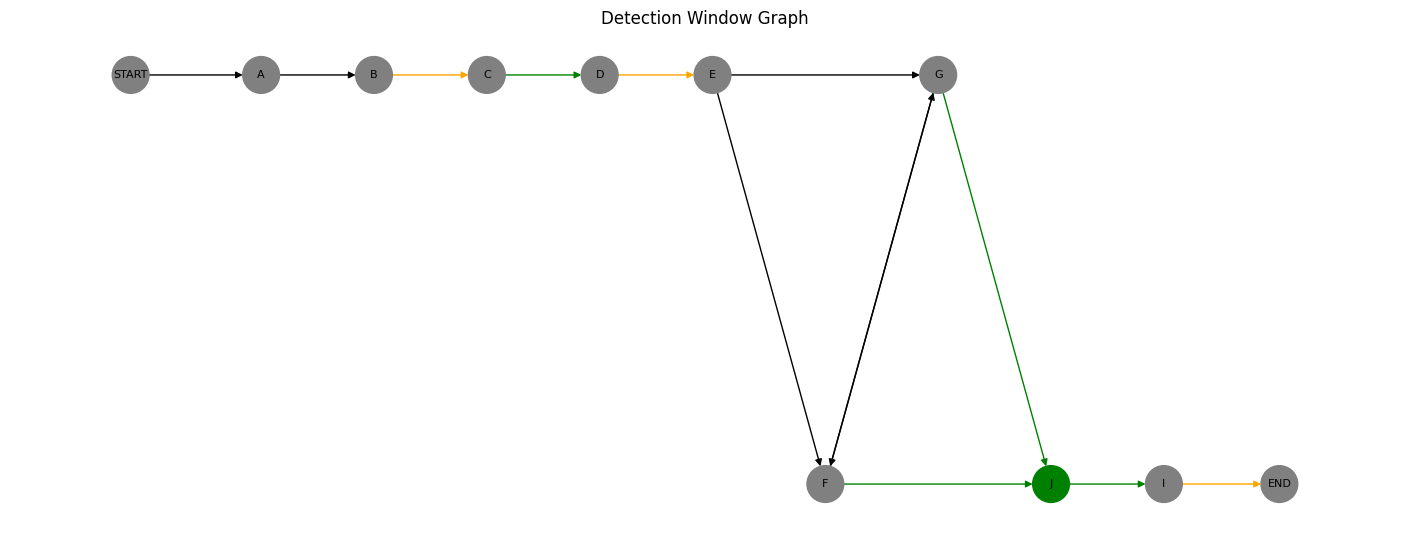

In [6]:
# Draw the graphs
draw_colored_graph(graph_reference, "Reference Window Graph", localization_results, characterization_results)
draw_colored_graph(graph_detection, "Detection Window Graph", localization_results, characterization_results)

# Characterization - Patterns

### Common control-flow change patterns in business processes: 
- SRE: Insert/delete an activity between two activities.
    - Template: from ->A->B-> to ->A->C->B-> or vice versa.
    - Characterization statement: After the drift, activity C is inserted (resp., deleted from) between activities A and B.

- PRE: Insert/delete an activity in/from parallel branch.
    - Template: from ->A->B->C-> to ->A->[B,D]->C-> or vice versa.
    - Characterization statement: 
        - Insert: After the drift, activity D is inserted between activities A and C in a parallel branch (with activity B). 
        - Delete: After the drift, activity D which was in a parallel branch (with activity B) between activities A and C is deleted.

- CRE: Insert/delete an activity in/from conditional branch.
    - Template: from ->A->B?->C-> to ->A->{D|B?}->C-> or vice versa.
    - Characterization statement: 
        - Insert: After the drift, activity D is inserted between activities A and C in a conditional branch (with activity B). 
        - Delete: After the drift, activity D which was in a conditional branch (with activity B) between activities A and C is deleted.

- CP: Duplicate an activity.
    - Template: from ->A->B->C-> to ->A->B->C->A-> or vice versa.
    - Characterization statement: After the drift, activity A, is inserted and became duplicated in the process (continues with SRE, PRE, or CRE).

- RP: Substitute an activity.
    - Template: from ->A->B->C-> to ->A->D->C->.
    - Characterization statement: After the drift, activity B, which was between activities A and C, is substituted by activity D.

- SW: Swap two activities.
    - Template: from ->A->B->C->D->E->F-> to ->A->E->C->D->B->F->.
    - Characterization statement: After the drift, activity B, which was between activities A and C, is swapped with activity E, which was between activities D and F.

- SM: Move an activity to between two activities.
    - Template: from ->A->B->C->D->E-> to ->A->C->D->B->E->.
    - Characterization statement: After the drift, activity B, which was between activities A and C, has moved to between activities D and E.

- CM: Move an activity into/out of conditional branch.
    - Template: from ->A->B->C->D->E?->F-> to ->A->C->D->{B|E?}->F-> or vice versa.
    - Characterization statement: After the drift, activity B, which was between activities A and C, has moved to between activities D and F and in a conditional branch (with activity E).

- PM: Move an activity into/out of parallel branch.
    - Template: from ->A->B->C->D->E->F-> to ->A->C->D->[B,E]->F-> or vice versa.
    - Characterization statement: After the drift, activity B, which was between activities A and C, has moved to between activities D and F and in a parallel branch with activity E.

- CF: Make activity mutually exclusive/sequential.
    - Template: from ->A->{B|C}->D-> to ->A->B->C->D-> or vice versa.
    - Characterization statement: Before the drift, activities B and C were mutually exclusive (resp., sequential), while after the drift, they are sequential (resp., mutually exclusive).

- PL: Make activities parallel/sequential.
    - Template: from ->A->[B,C]->D-> to ->A->B->C->D-> or vice versa.
    - Characterization statement: Before the drift, activities B and C were parallel (resp., sequential), while after the drift, they are sequential (resp., parallel).

- CD: Synchronize two activities.
    - Template: from ->A->[B,{C|D}]->E-> to ->A->[B->C,{C|D}]->E-> or vice versa.
    - Characterization statement: Before the drift, activities B and C were parallel (resp., synchronized), while after the drift they are synchronized (resp., parallel).

- LP: Make activities loopable/non-loopable.
    - Template: from ->A->B->C->D->E-> to ->A->B->C->D->{loop to B}->E-> or vice versa.
    - Characterization statement: After the drift, activities B, C and D have become loopable/non-loopable.

- CD: Make an activity skippable/non-skippable.
    - Template: from ->A->B->C-> to ->A->B?->C-> or vice versa.
    - Characterization statement: After the drift, activity B has become skippable/non-skippable.

- FR: Change branching frequency.
    - Template: from ->A->{B(40%)|C(60%)}->V-> to ->A->{B(70%)|C(30%)}->V-> or vice versa.
    - Characterization statement: After the drift, following activity A, branch of activity B is more frequently executed, while branch of activity C is less frequently executed.

### Custom BPMN-Like Text Representation Guide:

- Sequential Activities:
    - Represented as: A->B->C
    - Example: One activity following another in sequence.

- AND Gateway (Parallel Processing):
    - Represented as: A->[B,C]->D
    - Example: Activity A leads to parallel activities B and C, which then converge before moving to D. The square brackets [ ] denote parallel activities.

- XOR Gateway (Exclusive Decision):
    - Represented as: A->{B|C}->D
    - Example: Activity A leads to a decision point where either B or C is chosen, but not both. The curly braces { } with a vertical bar | indicate an XOR decision.

- Optional or skippable Activity:
    - Represented as: A->B?->C
    - Example: Activity B, between A and C, is optional or can be skipped. The question mark ? after an activity denotes that it is optional/skippable, leading to either A->B->C or A->C.

- Loopable Flow:
    - Format: A->B->C->{loop to A}->D
    - Example: Normal flow is A->B->C->D, but there's a loop from C back to A.

- XOR Gateway with Percentages:
    - Format: A->{B(60%)|C(40%)}->D
    - Example: After A, there's a 60% chance of choosing B and a 40% chance of choosing C, before moving to D.

- Combining Gateways:
    - Represented as: A->{B->[D,E]|C}->F
    - Example: A combination of AND and XOR gateways, where A leads to an XOR decision between B (which further leads to parallel activities D and E) and C, before proceeding to F.

Note: This guide is a custom representation for BPMN-like processes in text format. The symbols used (->, [ ], { }, ?) are part of the notation developed for this specific purpose.

In [123]:
import pm4py
from pm4py.objects.dfg.obj import DFG
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

def create_dfg_from_dataset(dataset):
    # Creating a DFG from the dataset
    dfg_transitions = {(row['From'], row['To']): row['Frequency'] for index, row in dataset.iterrows() if row['Frequency'] > 0}

    # Identifying real start activities
    real_start_activities = set(to for from_, to in dfg_transitions if from_ == 'START')
    start_activities_freq = {activity: dfg_transitions[('START', activity)] for activity in real_start_activities}

    # Identifying real end activities
    real_end_activities = set(from_ for from_, to in dfg_transitions if to == 'END')
    end_activities_freq = {activity: dfg_transitions[(activity, 'END')] for activity in real_end_activities}

    # Removing transitions that involve 'START' and 'END'
    dfg_transitions = {k: v for k, v in dfg_transitions.items() if 'START' not in k and 'END' not in k}

    return create_dfg_from_transitions(dfg_transitions, start_activities_freq, end_activities_freq)

def create_dfg_from_transitions(dfg_transitions, start_activities_freq, end_activities_freq):
    dfg = DFG()

    # Adding transitions to the DFG
    for (from_act, to_act), count in dfg_transitions.items():
        dfg.graph[(from_act, to_act)] += count

    # Adding real start activities
    for act, count in start_activities_freq.items():
        dfg.start_activities[act] += count

    # Adding real end activities
    for act, count in end_activities_freq.items():
        dfg.end_activities[act] += count

    return dfg

# Usage
reference_dfg = create_dfg_from_dataset(reference_window_df)
display(reference_dfg)
detection_dfg = create_dfg_from_dataset(detection_window_df)
display(detection_dfg)

Counter({('A', 'B'): 100, ('H', 'I'): 100, ('I', 'I'): 97, ('B', 'C'): 50, ('B', 'D'): 50, ('C', 'E'): 50, ('D', 'E'): 50, ('E', 'F'): 50, ('E', 'G'): 50, ('F', 'G'): 50, ('F', 'H'): 50, ('G', 'F'): 50, ('G', 'H'): 50})

Counter({('A', 'B'): 100, ('B', 'C'): 100, ('C', 'D'): 100, ('D', 'E'): 100, ('J', 'I'): 100, ('E', 'F'): 60, ('F', 'G'): 60, ('G', 'J'): 60, ('E', 'G'): 40, ('F', 'J'): 40, ('G', 'F'): 40})

In [124]:
def compare_dfgs(dfg1, dfg2):
    # Get transitions
    dfg1_transitions = set(dfg1.graph.keys())
    dfg2_transitions = set(dfg2.graph.keys())

    # Calculate new, deleted, and altered transitions
    new_transitions = dfg2_transitions - dfg1_transitions
    deleted_transitions = dfg1_transitions - dfg2_transitions
    
    # Get activities
    dfg1_activities = set(t[0] for t in dfg1.graph.keys()) | set(t[1] for t in dfg1.graph.keys())
    dfg2_activities = set(t[0] for t in dfg2.graph.keys()) | set(t[1] for t in dfg2.graph.keys())

    # Calculate new and deleted activities
    new_activities = dfg2_activities - dfg1_activities
    deleted_activities = dfg1_activities - dfg2_activities
    
    # Get start and end activities
    dfg1_start_activities = set(dfg1.start_activities.keys())
    dfg2_start_activities = set(dfg2.start_activities.keys())
    dfg1_end_activities = set(dfg1.end_activities.keys())
    dfg2_end_activities = set(dfg2.end_activities.keys())

    # Calculate new and deleted start and end activities
    new_start_activities = dfg2_start_activities - dfg1_start_activities
    deleted_start_activities = dfg1_start_activities - dfg2_start_activities
    new_end_activities = dfg2_end_activities - dfg1_end_activities
    deleted_end_activities = dfg1_end_activities - dfg2_end_activities

    categorized_changes = {
        'New Transitions': list(new_transitions),
        'Deleted Transitions': list(deleted_transitions),
        'New Activities': list(new_activities),
        'Deleted Activities': list(deleted_activities),
        'New Start Activities': list(new_start_activities),
        'Deleted Start Activities': list(deleted_start_activities),
        'New End Activities': list(new_end_activities),
        'Deleted End Activities': list(deleted_end_activities)
    }

    return categorized_changes

# Compare DFGs
categorized_changes = compare_dfgs(reference_dfg, detection_dfg)
# Results contains all the different types of changes

# Display the changes
display(categorized_changes)

{'New Transitions': [('F', 'J'), ('J', 'I'), ('G', 'J'), ('C', 'D')],
 'Deleted Transitions': [('C', 'E'),
  ('B', 'D'),
  ('H', 'I'),
  ('I', 'I'),
  ('F', 'H'),
  ('G', 'H')],
 'New Activities': ['J'],
 'Deleted Activities': ['H'],
 'New Start Activities': [],
 'Deleted Start Activities': [],
 'New End Activities': [],
 'Deleted End Activities': []}

In [125]:
def collect_activities_by_operator(node, results, current_operator=None):
    if node.operator is None:
        # It's an activity
        if current_operator is not None and node.label is not None:
            operator_name = current_operator.name  # Get operator name
            if operator_name not in results:
                results[operator_name] = []
            results[operator_name].append(node.label)
    else:
        # It's an operator, update the current operator
        current_operator = node.operator
        for child in node.children:
            collect_activities_by_operator(child, results, current_operator)

def analyze_process_tree_by_operator(process_tree):
    results = {}
    collect_activities_by_operator(process_tree, results)
    return results

# Example usage
reference_process_tree = inductive_miner.apply(reference_dfg)
reference_operators = analyze_process_tree_by_operator(reference_process_tree)
display(reference_operators)

detection_process_tree = inductive_miner.apply(detection_dfg)
detection_operators = analyze_process_tree_by_operator(detection_process_tree)
display(detection_operators)

c:\Users\anton\OneDrive\_Cloud Disk\Projetos de programação\Git\Transition_Matrix_Process_Drift\.venv\Lib\site-packages\pm4py\algo\discovery\inductive\algorithm.py:78: UserWarning: Inductive Miner Variant requested for DFG artefact is not IMD, resorting back to IMD
  warnings.warn('Inductive Miner Variant requested for DFG artefact is not IMD, resorting back to IMD')


{'SEQUENCE': ['A', 'B', 'E', 'H'],
 'XOR': ['D', 'C'],
 'PARALLEL': ['G', 'F'],
 'LOOP': ['I']}

{'SEQUENCE': ['A', 'B', 'C', 'D', 'E', 'J', 'I'], 'PARALLEL': ['G', 'F']}

In [126]:
# pm4py.view_dfg(reference_dfg.graph, reference_dfg.start_activities, reference_dfg.end_activities)
# pm4py.view_dfg(detection_dfg.graph, detection_dfg.start_activities, detection_dfg.end_activities)

# reference_bpmn = pm4py.discover_bpmn_inductive(reference_dfg)
# pm4py.view_bpmn(reference_bpmn)

# detection_bpmn = pm4py.discover_bpmn_inductive(detection_dfg)
# pm4py.view_bpmn(detection_bpmn)

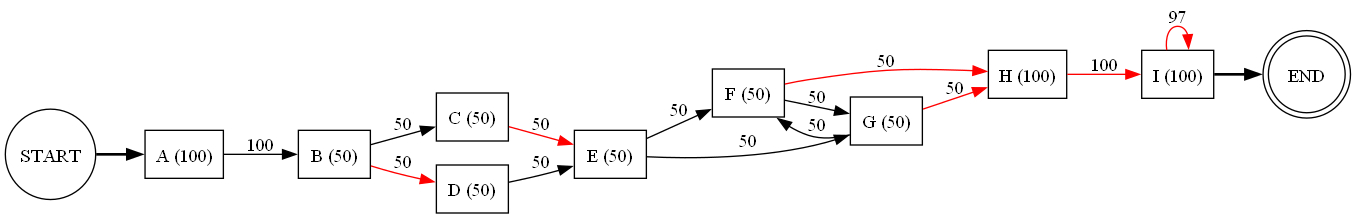

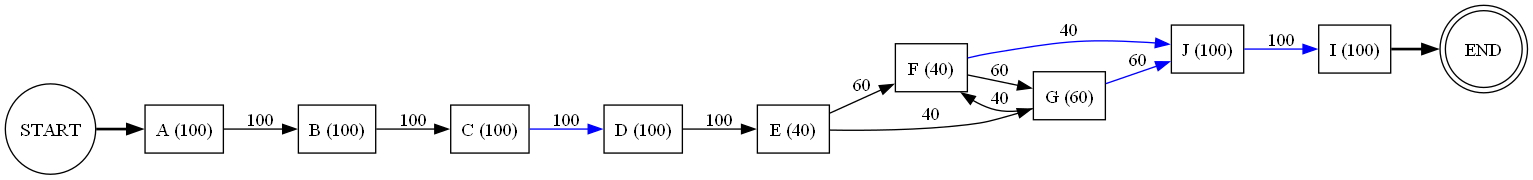

In [104]:
from graphviz import Digraph
from IPython.display import display, Image

def dfg_visualization(dfg, start_activities, end_activities, new_transitions, deleted_transitions, altered_transitions, bgcolor="white", rankdir="LR"):
    dot = Digraph(engine='dot', graph_attr={'bgcolor': bgcolor, 'rankdir': rankdir})

    # Create a unique start and end node for visualization
    dot.node('start', shape='circle', label='START', width='0.8', style='filled', fillcolor='white')
    dot.node('end', shape='doublecircle', label='END', width='0.8', style='filled', fillcolor='white')

    # Add nodes and edges to the graph
    for (source, target), count in dfg.items():
        # Set node shapes and labels
        source_label = f"{source} ({start_activities.get(source, count)})"
        target_label = f"{target} ({end_activities.get(target, count)})"

        # Add nodes
        dot.node(source, label=source_label, shape='box', style='filled', fillcolor='white')
        dot.node(target, label=target_label, shape='box', style='filled', fillcolor='white')

        # Set edge colors based on transition type
        color = 'black'
        if (source, target) in new_transitions:
            color = 'blue'
        elif (source, target) in deleted_transitions:
            color = 'red'

        # Add edges
        dot.edge(source, target, label=str(count), color=color)

    # Connect the start node to the real start activities and the real end activities to the end node
    for act in start_activities:
        if act not in end_activities:  # Avoid connecting end activities again
            dot.edge('start', act, style='bold')

    for act in end_activities:
        if act not in start_activities:  # Avoid connecting start activities again
            dot.edge(act, 'end', style='bold')

    # Render and display the graph inline in Jupyter Notebook
    png_data = dot.pipe(format='png')
    display(Image(png_data))

# Usage example
dfg_visualization(reference_dfg.graph, reference_dfg.start_activities, reference_dfg.end_activities, new_trans, del_trans, alt_trans)
dfg_visualization(detection_dfg.graph, detection_dfg.start_activities, detection_dfg.end_activities, new_trans, del_trans, alt_trans)


In [ ]:
import os
from langchain.llms import OpenAI
from langchain.chains import SimpleChain

# insert API_TOKEN in the file to be read here
with open('Temp/open_ai_token.txt', 'r') as file:
    os.environ["OPENAI_API_KEY"] = file.read().rstrip()

# Instanciating a proprietary LLM from OpenAI
llm = OpenAI(model_name="text-davinci-003", temperature=0)

# Initialize LangChain with the GPT model
chain = SimpleChain(llm=llm)

In [ ]:
# Example of how to structure the analysis
def analyze_patterns(localization_results, characterization_results, pattern_definitions):
    # Convert pattern definitions into a readable format for GPT
    readable_patterns = convert_to_readable_format(pattern_definitions)

    # Prepare your process mining data
    process_data = prepare_process_data(localization_results, characterization_results)

    # Combine the data and pattern definitions into a query
    query = combine_query(process_data, readable_patterns)

    # Use LangChain to analyze the query
    response = chain.run_chain(query)
    return response

# Explanation

In [ ]:
# Get contextualization of the process by the user for getting a holistic conclusion about the concept drift

# Test

In [ ]:
import os
from langchain.llms import OpenAI
from langchain.agents import create_pandas_dataframe_agent 

# insert API_TOKEN in the file to be read here
with open('Temp/open_ai_token.txt', 'r') as file:
    os.environ["OPENAI_API_KEY"] = file.read().rstrip()


In [ ]:
# Instanciating a proprietary LLM from OpenAI
llm = OpenAI(model_name="text-davinci-003", temperature=0)

In [ ]:
# The LLM takes a prompt as an input and outputs a completion
# prompt = "Alice has a parrot. What animal is Alice's pet?"
# completion = llm(prompt)
# print(completion)

In [ ]:
agent = create_pandas_dataframe_agent(llm, reference_window, verbose=True)
agent.run("Summary what have in the dataset")


In [ ]:
# def process_tree_to_dict(process_tree):
#     """
#     Converts a process tree to a dictionary format.
#     """
#     tree_dict = {'operator': None, 'children': [], 'activity': None}

#     if process_tree.operator is not None:
#         tree_dict['operator'] = str(process_tree.operator)
#         for child in process_tree.children:
#             tree_dict['children'].append(process_tree_to_dict(child))
#     else:
#         tree_dict['activity'] = process_tree.label

#     return tree_dict

# def compare_trees(tree1, tree2):
#     """
#     Compares two process trees and extracts differences in terms of activities and operators.
#     """

#     def compare_nodes(node1, node2):
#         """
#         Compare two nodes from the process trees.
#         """
#         differences = []
#         if node1['activity'] != node2['activity']:
#             differences.append(f"Activity changed from '{node1['activity']}' to '{node2['activity']}'")

#         if node1['operator'] != node2['operator']:
#             differences.append(f"Operator changed from '{node1['operator']}' to '{node2['operator']}'")

#         len_children_1 = len(node1['children'])
#         len_children_2 = len(node2['children'])

#         if len_children_1 != len_children_2:
#             differences.append(f"Number of children changed from {len_children_1} to {len_children_2}")

#         for i in range(min(len_children_1, len_children_2)):
#             differences.extend(compare_nodes(node1['children'][i], node2['children'][i]))

#         return differences

#     return compare_nodes(tree1, tree2)

# # Example usage
# # Load your process trees here
# reference_process_tree = inductive_miner.apply(reference_dfg) #, parameters={'noise_threshold': 0.01}
# detection_process_tree = inductive_miner.apply(detection_dfg) #, parameters={'noise_threshold': 0.01}

# # Convert process trees to dictionary format
# reference_tree_dict = process_tree_to_dict(reference_process_tree)
# detection_tree_dict = process_tree_to_dict(detection_process_tree)

# # Compare trees and extract differences
# differences = compare_trees(reference_tree_dict, detection_tree_dict)
# display(reference_tree_dict)
# display(detection_tree_dict)

# # Print or return the differences for LLM analysis
# display(differences)

In [ ]:
# def collect_activities_by_operator(node, results, current_path=[], current_operator=None):
#     if node.operator is None:
#         # It's an activity
#         if current_operator == "SEQUENCE" and node.label is not None:
#             # Add relationship to the previous activity in SEQUENCE
#             if current_path:
#                 prev_activity = current_path[-1]
#                 pair = (prev_activity, node.label)
#                 results.setdefault("SEQUENCE", []).append(pair)
#             current_path.append(node.label)
#         elif current_operator in ["PARALLEL", "XOR"] and node.label is not None:
#             # Record the activity in the current path
#             current_path.append(node.label)
#         elif current_operator == "LOOP" and node.label is not None:
#             # Add relationship to all other activities in LOOP
#             for activity in current_path:
#                 if activity != node.label:
#                     pair = (activity, node.label)
#                     results.setdefault("LOOP", []).append(pair)
#             current_path.append(node.label)
#     else:
#         # It's an operator, update the current operator
#         if node.operator.name in ["PARALLEL", "XOR"]:
#             # For PARALLEL and XOR, handle each child as a separate path
#             paths = []
#             for child in node.children:
#                 child_path = []
#                 collect_activities_by_operator(child, results, child_path, node.operator.name)
#                 paths.append(child_path)

#             # Combine activities in different paths for PARALLEL and XOR
#             for path1 in paths:
#                 for path2 in paths:
#                     if path1 != path2:
#                         for activity1 in path1:
#                             for activity2 in path2:
#                                 pair = (activity1, activity2)
#                                 results.setdefault(node.operator.name, []).append(pair)
#         else:
#             # For other operators, continue with the current path
#             for child in node.children:
#                 collect_activities_by_operator(child, results, current_path, node.operator.name)



# # def collect_activities_by_operator(node, results, operator_path=[]):
# #     if node.operator is None:
# #         # It's an activity
# #         if operator_path and node.label is not None:
# #             for op in operator_path:  # Iterate over all operators in the path
# #                 operator_name = op.name  # Get the name of the operator
# #                 if operator_name not in results:
# #                     results[operator_name] = []
# #                 if node.label not in results[operator_name]:  # Avoid duplicate entries
# #                     results[operator_name].append(node.label)
# #     else:
# #         # It's an operator
# #         new_path = operator_path + [node.operator]  # Extend the current operator path
# #         for child in node.children:
# #             collect_activities_by_operator(child, results, new_path)



# # def collect_activities_by_operator(node, results, current_operator=None):
# #     if node.operator is None:
# #         # It's an activity
# #         if current_operator is not None and node.label is not None:
# #             operator_name = current_operator.name  # Get operator name
# #             if operator_name not in results:
# #                 results[operator_name] = []
# #             results[operator_name].append(node.label)
# #     else:
# #         # It's an operator, update the current operator
# #         current_operator = node.operator
# #         for child in node.children:
# #             collect_activities_by_operator(child, results, current_operator)




# def analyze_process_tree_by_operator(process_tree):
#     results = {}
#     collect_activities_by_operator(process_tree, results)
#     return results


# def compare_control_flow_operator(reference_dfg, detection_dfg):

#     # Call the function to transform the dfg in process trees
#     reference_process_tree = inductive_miner.apply(reference_dfg) #, parameters={'noise_threshold': 0.01}
#     detection_process_tree = inductive_miner.apply(detection_dfg) #, parameters={'noise_threshold': 0.01}

#     # Call function to get the activities operator and insert a prefix
#     reference_operators =  analyze_process_tree_by_operator(reference_process_tree) 
#     detection_operators = analyze_process_tree_by_operator(detection_process_tree) 

#     result = {}
#     all_keys = set(reference_operators.keys()).union(set(detection_operators.keys()))
#     for key in all_keys:
#         # Find items in detection_operators not in reference_operators (new items)
#         new_items = list(set(detection_operators.get(key, [])) - set(reference_operators.get(key, [])))
#         result[f'{key}_new'] = new_items

#         # Find items in reference_operators not in detection_operators (deleted items)
#         deleted_items = list(set(reference_operators.get(key, [])) - set(detection_operators.get(key, [])))
#         result[f'{key}_deleted'] = deleted_items

#     # Insert a suffix
#     reference_operators = {str(key) + "_reference": val for key, val in reference_operators.items()}
#     detection_operators = {str(key) + "_detection": val for key, val in detection_operators.items()}

#     return reference_operators | detection_operators | result

# # Compare DFGs
# control_flow_operator_changes_result = compare_control_flow_operator(reference_dfg, detection_dfg)

# # Show the changes
# display(control_flow_operator_changes_result)